### Task 2 - Temporal Network Analysis - January 2018
#### <i>Abdel K. Bokharouss, Joris Rombouts, Bart van Helvert, Remco Surtel</i>

### <font color = "green">imports and preparation</font>

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import datetime
import tkinter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [2]:
temp_nw = pd.read_table("./data/tgraph_real_wikiedithyperlinks.txt", header = None, sep = " ",
                       names = ["src", "trg", "start", "end"])

In [3]:
temp_nw.head()

,src,trg,start,end
0,1,6,1028243088,1120917090
1,1,8,1029885647,1136791625
2,1,9,1029885647,1136791625
3,1,3,1028243088,1143227562
4,1,3,1146727453,1148998304


In [4]:
temp_nw['start'] = pd.to_datetime(temp_nw['start'], unit = 's') #convert Unix timestamps to date time, utc = 0
temp_nw['end'] = pd.to_datetime(temp_nw['end'], unit = 's')

In [5]:
#test function for unix time stamps to datetime
print(
    datetime.datetime.fromtimestamp(
        int("1028243088")
    ).strftime('%Y-%m-%d %H:%M:%S')
)

2002-08-02 01:04:48


In [6]:
temp_nw.head(10)

,src,trg,start,end
0,1,6,2002-08-01 23:04:48,2005-07-09 13:51:30
1,1,8,2002-08-20 23:20:47,2006-01-09 07:27:05
2,1,9,2002-08-20 23:20:47,2006-01-09 07:27:05
3,1,3,2002-08-01 23:04:48,2006-03-24 19:12:42
4,1,3,2006-05-04 07:24:13,2006-05-30 14:11:44
5,1,5,2002-08-01 23:04:48,2007-07-10 19:45:45
6,1,2,2002-08-01 23:04:48,2007-07-10 19:45:45
7,1,3,2006-06-06 12:47:15,2007-07-10 19:45:45
8,1,4,2002-08-01 23:04:48,2007-07-10 19:45:45
9,1,7,2002-08-01 23:04:48,2007-07-10 19:45:45


In [7]:
fh = open("data/tgraph_real_wikiedithyperlinks.txt", 'rb')
G_temp = nx.read_edgelist(fh,create_using=nx.DiGraph(), data=(('start',int), ('end', int)))
fh.close()

In [8]:
#nx.write_edgelist(G_temp, "G_temp.edgelist")

In [9]:
def gen_df_between(df_in, t1, t2):
    return df_in.loc[((df_in['start'] >= t1) & (df_in['start'] < t2)) 
              | ((df_in['end'] >= t1) & (df_in['end'] < t2)) 
              | ((df_in['start'] < t1) & (df_in['end'] >= t2))]

### Temporal Network Analysis
For the second task, the time information of each edge is taken into consideration. The most used temporal network analysis method is snapshot-based analysis. For each measure we need to find time-scales that gives us interesting result. It is important that the time intervals are consisently chosen during the same measure, but the time intervals can be different for each measure. This is because patterns in temporal networks can occur at different time scales. 
First, we explore the temporal networks, by plotting a few histograms. The first histogram gives us a insight how many links are added in each year.

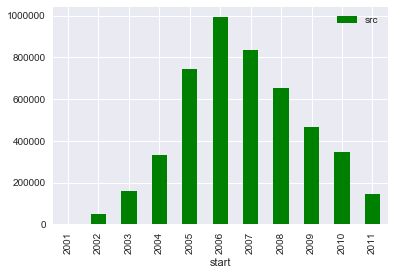

In [10]:
#plot that shows how many links are added in each year
temp_nw['src'].groupby(temp_nw["start"].dt.year).count().plot(kind="bar", legend=True, color = 'green')
plt.show()

The histogram looks like a bell curve. This means that most of the links are added in the years 2005-2008. Let's look if the removal of the links also have a bell shaped curve. 

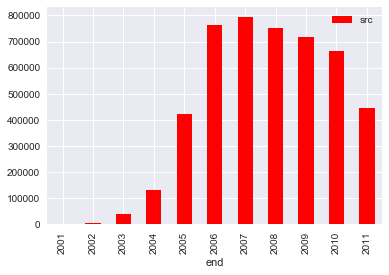

In [11]:
#plot that shows how many links are removed in each year
temp_nw['src'].groupby(temp_nw["end"].dt.year).count().plot(kind="bar", legend=True, color='red')
plt.show()

The histogram doesn't look like a bell curve. We actually see that the years 2006-2010 are the years in which most of the edges are removed. If we combine this with the information found above, we can conclude that the years 2006-2008 where the years in which the most links are added ánd removed from the wiki page. One can also be interested in the time duration of each link, i.e. how many years a link stays in the graph until it is removed. 

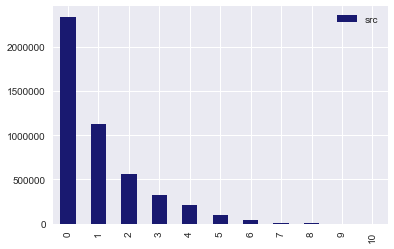

In [12]:
#plot which shows how many years each link remains in the graph bevore it is removed.
temp_nw['src'].groupby((temp_nw['end'].dt.year - temp_nw['start'].dt.year)).count().plot(kind="bar", legend=True, color='midnightblue')
plt.show()

From the histogram above we can see that a lot of links have a very short time duration in the graph. Most of the links are added and removed from the wiki page within a year. Furthermore we see that the other links doesn't stay long either in the graph. We can say that most of the links remain zero to two years in the network.

### Cluster Coefficient: Temporal Network
As we have seen in the static network analysis, cluster coefficient is very strong related to the largest connected component and the average degree of the neighbor nodes (which is treated in the Assortativity analysis). Measuring the cluster coefficient in a temporal network, where each edge has a start and end time, can give very interesting results. The goal of this measure in temporal network analysis is that we try to find time scales where the clustering coefficient of the graph (i.e. the average of the cluster coefficients of all the nodes) is very low or high. We can relate this cluster coefficient to for example how many nodes or edges there currently are on that particular timestamp, or what the degree distribution is of each node. The most difficult part is to choose propiate time intervals. Thanks to the explorative analysis above, the histogram give us some insight in what time intervals could be interesting to choose. Note that once one time interval is chosen, we will consistently use this "length" during the analysis of the measure. The histograms above only information about the addition and removal of links in the network. However, we saw from the static analysis that the (average) clustering coefficient depends on the average neighbor degree. Larger the neighbor degree is in the network, the larger the clustering coefficient. This is because the numerator of the fraction in the clustering coefficient formula basicly is the average neighbor degree of the node we want to calculate the clustering coefficient of. Also the average degree of all the nodes in the network are interesting to know how they change over time. We will plot these two statistics of the network in the next cells. 

In [13]:
def total_average__neighbor_deg_per_year(df_temporal, t_1_year, t_2_year):
    t_1 = datetime.datetime(t_1_year, 1, 1, 0, 0, 0)
    t_2 = datetime.datetime(t_2_year, 1, 1, 0, 0, 0)
 
    df_year = gen_df_between(df_temporal, t_1, t_2)
    G_year = nx.from_pandas_dataframe(df_year, 'src', 'trg', edge_attr=None, create_using=nx.DiGraph())
    average_deg = dict(nx.average_neighbor_degree(G_year, source='out', target='in'))
    average_deg_graph = sum(average_deg.values()) / len(G_year)

    return average_deg_graph

In [14]:
avg_neighbor_deg = { 'avg neighbor deg': [total_average__neighbor_deg_per_year(temp_nw, i, i+1) for i in range(2001,2012)], 'time_interval' : [str(i)+"-"+str(i+1) for i in range(2001,2012)]}
df_avg_neighbor_deg = pd.DataFrame(data=avg_neighbor_deg)

In [15]:
df_avg_neighbor_deg.head(10)

,avg neighbor deg,time_interval
0,0.083679,2001-2002
1,23.958797,2002-2003
2,24.370012,2003-2004
3,54.258272,2004-2005
4,208.937909,2005-2006
5,310.030716,2006-2007
6,240.336918,2007-2008
7,219.782257,2008-2009
8,220.095069,2009-2010
9,116.577892,2010-2011


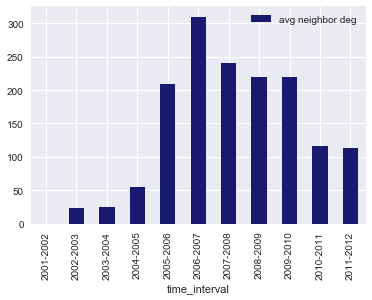

In [16]:
df_avg_neighbor_deg.plot.bar(x = 'time_interval', color='midnightblue');
plt.show()

The histogram shows us that the average neighbor degree in the temporal network is very high in the period 2005-2007 and 2006-2008. These are also the two periods where the network contains the most edges, therefore the average degree of each node increases. What is interesting, is that the degree in last two years are also quite high. This is interesting, because from the histograms above we say that these periods (2008-2010 and 2009-2011) are the periods where there are more links removed from the network then links that are added to the network. Therefore we would expect that the average degree of the neighbors would decrease, but the bar plot shows something differently. However, note a high average neighbor degree of a node does immediately imply that the cluster coefficient of that node becomes high. What could also be interesting is just the average degree of each node themself. Lets plot this in the cell below. 

In [17]:
def average_deg_full_graph(df_temporal, t_1_year, t_2_year):
    t_1 = datetime.datetime(t_1_year, 1, 1, 0, 0, 0)
    t_2 = datetime.datetime(t_2_year, 1, 1, 0, 0, 0)
    
    df_year = gen_df_between(df_temporal, t_1, t_2)
    G_year = nx.from_pandas_dataframe(df_year, 'src', 'trg', edge_attr=None, create_using=nx.DiGraph())
    average = sum(dict(G_year.out_degree()).values()) / float(nx.number_of_nodes(G_year))
    
    return average

In [18]:
avg_deg = { 'avg deg': [average_deg_full_graph(temp_nw, i, i+1) for i in range(2001,2012)], 'time_interval' : [str(i)+"-"+str(i+1) for i in range(2001,2012)]}
df_avg_deg = pd.DataFrame(data=avg_deg)

In [19]:
df_avg_deg.head(10)

,avg deg,time_interval
0,1.167268,2001-2002
1,2.944087,2002-2003
2,3.749014,2003-2004
3,4.121738,2004-2005
4,4.422624,2005-2006
5,4.125322,2006-2007
6,3.777225,2007-2008
7,3.268622,2008-2009
8,2.919088,2009-2010
9,2.401774,2010-2011


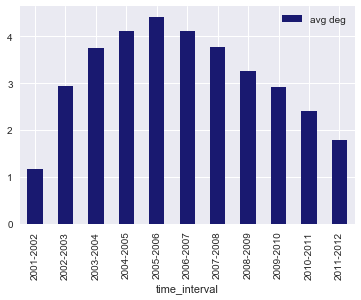

In [20]:
df_avg_deg.plot.bar(x = 'time_interval', color='midnightblue');
plt.show()

We see that the average out degree is the higest (let's say above three) in the periods 2003 to 2007. Because we are talking over a periods of 12 years, we will choose the following timestamps for the temporal network analysis, so that we can make a much better analysis over these different time intervals:
* $2001-2004$, so $T_1 = 2001$ and $T_2 = 2004$ (i.e. the first three bars in the bar plot above) This graph is called $G_{temp-1}$ 
* $2004-2007$, so $T_3 = 2004$ and $T_4 = 2007$ (i.e. the fourth, fift and sixt bars in the bar plot above) This graph is called $G_{temp-2}$ 
* $2007-2010$, so $T_5 = 2007$ and $T_6 = 2010$ (i.e. the seventh, eighth and ninth bars in the bar plot above) This graph is called $G_{temp-3}$ 
* $2010-2012$, so $T_7 = 2010$ and $T_8 = 2012$ (i.e. the tenth and eleventh bars in the bar plot above) This graph is called $G_{temp-4}$ 

In [21]:
def clustering_directed(G):
    td_iter = nx.cluster._triangles_and_degree_iter(G)
    clusterc = {v: 0 if t == 0 else (t) / (d * (d - 1)) for
                        v, d, t, _ in td_iter}
    return clusterc

In [22]:
def average_clustering_directed(G):
    c = clustering_directed(G).values()
    return sum(c) / len(c)

We use the same functions for calculating the clustering coefficient for each node in a directed graph as in task 1. For the clustering coefficient of the graph (i.e. the average the cluster coefficient of each node), we also use the same function as in task 1. Lets create the graphs for each time interval and write the cluster coefficient scores of each node to a seperate csv file, so that we only have to run these cells once. 

In [23]:
t_1 = datetime.datetime(2001, 1, 1, 0, 0, 0)
t_2 = datetime.datetime(2004, 1, 1, 0, 0, 0)
t_3 = datetime.datetime(2004, 1, 1, 0, 0, 0)
t_4 = datetime.datetime(2007, 1, 1, 0, 0, 0)
t_5 = datetime.datetime(2007, 1, 1, 0, 0, 0)
t_6 = datetime.datetime(2010, 1, 1, 0, 0, 0)
t_7 = datetime.datetime(2010, 1, 1, 0, 0, 0)
t_8 = datetime.datetime(2012, 1, 1, 0, 0, 0)

In [24]:
df_temp_1 = gen_df_between(temp_nw, t_1, t_2)
G_temp_1 = nx.from_pandas_dataframe(df_temp_1, 'src', 'trg', edge_attr=None, create_using=nx.DiGraph())

df_temp_2 = gen_df_between(temp_nw, t_3, t_4)
G_temp_2 = nx.from_pandas_dataframe(df_temp_2, 'src', 'trg', edge_attr=None, create_using=nx.DiGraph())

df_temp_3 = gen_df_between(temp_nw, t_5, t_6)
G_temp_3 = nx.from_pandas_dataframe(df_temp_3, 'src', 'trg', edge_attr=None, create_using=nx.DiGraph())

df_temp_4 = gen_df_between(temp_nw, t_7, t_8)
G_temp_4 = nx.from_pandas_dataframe(df_temp_4, 'src', 'trg', edge_attr=None, create_using=nx.DiGraph())

In [25]:
#cluster_score_temp_1 = clustering_directed(G_temp_1)
#cluster_score_temp_2 = clustering_directed(G_temp_2)
#cluster_score_temp_3 = clustering_directed(G_temp_3)
#cluster_score_temp_4 = clustering_directed(G_temp_4)

In [26]:
#df_cluster_score_temp_1 = pd.DataFrame(list(cluster_score_temp_1.items()), columns=['Node', 'Cluster Coefficient'])
#df_cluster_score_temp_2 = pd.DataFrame(list(cluster_score_temp_2.items()), columns=['Node', 'Cluster Coefficient'])
#df_cluster_score_temp_3 = pd.DataFrame(list(cluster_score_temp_3.items()), columns=['Node', 'Cluster Coefficient'])
#df_cluster_score_temp_4 = pd.DataFrame(list(cluster_score_temp_4.items()), columns=['Node', 'Cluster Coefficient'])

In [27]:
#df_cluster_score_temp_1.to_csv('task2_cluster/df_cluster_score_temp_1.csv')
#df_cluster_score_temp_2.to_csv('task2_cluster/df_cluster_score_temp_2.csv')
#df_cluster_score_temp_3.to_csv('task2_cluster/df_cluster_score_temp_3.csv')
#df_cluster_score_temp_4.to_csv('task2_cluster/df_cluster_score_temp_4.csv')

In [28]:
df_cluster_score_temp_1 = pd.read_csv('task2_cluster/df_cluster_score_temp_1.csv')
df_cluster_score_temp_2 = pd.read_csv('task2_cluster/df_cluster_score_temp_2.csv')
df_cluster_score_temp_3 = pd.read_csv('task2_cluster/df_cluster_score_temp_3.csv')
df_cluster_score_temp_4 = pd.read_csv('task2_cluster/df_cluster_score_temp_4.csv')

df_cluster_score_temp_1.drop(['Unnamed: 0'], axis = 1, inplace = True)
df_cluster_score_temp_2.drop(['Unnamed: 0'], axis = 1, inplace = True)
df_cluster_score_temp_3.drop(['Unnamed: 0'], axis = 1, inplace = True)
df_cluster_score_temp_4.drop(['Unnamed: 0'], axis = 1, inplace = True)

The score of each graph is in the four seperate dataframe files. Now that the cluster coefficient score of each node in each graph is calculated, the actual analysis can begin. Just as in task 1, we start looking for each graph how many nodes have a cluster coefficient of zero and one. Recall that nodes with a cluster coefficient of one form a clique, while nodes with a cluster coefficient of 0 are the centre of a star.

In [29]:
temp_1_clique = df_cluster_score_temp_1.loc[df_cluster_score_temp_1['Cluster Coefficient'] == 1.0].count()[0] #number of nodes with coefficient of 1, i.e. that are a clique
temp_2_clique = df_cluster_score_temp_2.loc[df_cluster_score_temp_2['Cluster Coefficient'] == 1.0].count()[0] #number of nodes with coefficient of 1, i.e. that are a clique
temp_3_clique = df_cluster_score_temp_3.loc[df_cluster_score_temp_3['Cluster Coefficient'] == 1.0].count()[0] #number of nodes with coefficient of 1, i.e. that are a clique
temp_4_clique = df_cluster_score_temp_4.loc[df_cluster_score_temp_4['Cluster Coefficient'] == 1.0].count()[0] #number of nodes with coefficient of 1, i.e. that are a clique
print("number of nodes with a cluster coefficient of 1 in G_temp_1: " + str(temp_1_clique)+ ". This equals "+str((round(temp_1_clique/ len(G_temp_1)*100,2)))+"% of the total nodes")
print("number of nodes with a cluster coefficient of 1 in G_temp_2: " + str(temp_2_clique)+ ". This equals "+str((round(temp_2_clique/ len(G_temp_2)*100,2)))+"% of the total nodes")
print("number of nodes with a cluster coefficient of 1 in G_temp_3: " + str(temp_3_clique)+ ". This equals "+str((round(temp_3_clique/ len(G_temp_3)*100,2)))+"% of the total nodes")
print("number of nodes with a cluster coefficient of 1 in G_temp_4: " + str(temp_4_clique)+ ". This equals "+str((round(temp_4_clique/ len(G_temp_4)*100,2)))+"% of the total nodes")

number of nodes with a cluster coefficient of 1 in G_temp_1: 45. This equals 0.08% of the total nodes
number of nodes with a cluster coefficient of 1 in G_temp_2: 666. This equals 0.18% of the total nodes
number of nodes with a cluster coefficient of 1 in G_temp_3: 860. This equals 0.15% of the total nodes
number of nodes with a cluster coefficient of 1 in G_temp_4: 251. This equals 0.06% of the total nodes


In [30]:
temp_1_star = df_cluster_score_temp_1.loc[df_cluster_score_temp_1['Cluster Coefficient'] == 0.0].count()[0] #number of nodes with coefficient of 1, i.e. that are a clique
temp_2_star = df_cluster_score_temp_2.loc[df_cluster_score_temp_2['Cluster Coefficient'] == 0.0].count()[0] #number of nodes with coefficient of 1, i.e. that are a clique
temp_3_star = df_cluster_score_temp_3.loc[df_cluster_score_temp_3['Cluster Coefficient'] == 0.0].count()[0] #number of nodes with coefficient of 1, i.e. that are a clique
temp_4_star = df_cluster_score_temp_4.loc[df_cluster_score_temp_4['Cluster Coefficient'] == 0.0].count()[0] #number of nodes with coefficient of 1, i.e. that are a clique
print("number of nodes with a cluster coefficient of 0 in G_temp_1: " + str(temp_1_star) + ". This equals "+str(int(round(temp_1_star/ len(G_temp_1)*100)))+"% of the total nodes")
print("number of nodes with a cluster coefficient of 0 in G_temp_2: " + str(temp_2_star) + ". This equals "+str(int(round(temp_2_star/ len(G_temp_2)*100)))+"% of the total nodes")
print("number of nodes with a cluster coefficient of 0 in G_temp_3: " + str(temp_3_star) + ". This equals "+str(int(round(temp_3_star/ len(G_temp_3)*100)))+"% of the total nodes")
print("number of nodes with a cluster coefficient of 0 in G_temp_4: " + str(temp_4_star) + ". This equals "+str(int(round(temp_4_star/ len(G_temp_4)*100)))+"% of the total nodes")

number of nodes with a cluster coefficient of 0 in G_temp_1: 45516. This equals 84% of the total nodes
number of nodes with a cluster coefficient of 0 in G_temp_2: 283205. This equals 77% of the total nodes
number of nodes with a cluster coefficient of 0 in G_temp_3: 464937. This equals 83% of the total nodes
number of nodes with a cluster coefficient of 0 in G_temp_4: 360676. This equals 93% of the total nodes


We see that the $G_{temp-3}$ contains the most nodes with a cluster coefficient of zero and one. However, we know from the bar plots at the beginning of this analysis that the average degree is the highest in the second graph $G_{temp-2}$. We will take a look at the average clustering coefficient of the entire graphs, to look if the number of cliques in a network will increase the overall clustering coefficient of a graph

In [31]:
avg_cluster_score_temp_1 = average_clustering_directed(G_temp_1)
avg_cluster_score_temp_2 = average_clustering_directed(G_temp_2)
avg_cluster_score_temp_3 = average_clustering_directed(G_temp_3)
avg_cluster_score_temp_4 = average_clustering_directed(G_temp_4)
print("The clustering coefficient of graph G_temp_1 = " + str(round(avg_cluster_score_temp_1,3)))
print("The clustering coefficient of graph G_temp_2 = " + str(round(avg_cluster_score_temp_2,3)))
print("The clustering coefficient of graph G_temp_3 = " + str(round(avg_cluster_score_temp_3,3)))
print("The clustering coefficient of graph G_temp_4 = " + str(round(avg_cluster_score_temp_4,3)))

The clustering coefficient of graph G_temp_1 = 0.029
The clustering coefficient of graph G_temp_2 = 0.035
The clustering coefficient of graph G_temp_3 = 0.024
The clustering coefficient of graph G_temp_4 = 0.009


The results of the cell above shows us that the second graph $G_{temp-2}$ has the highest cluster coefficient. This is what we expected. The bar plots earlier in this paragraph tells us that the period 2006-2007 has the highest average degree of each node, as well as the highest average neighbor degree of each node. The period 2006 - 2007 is in $G_{temp-2}$, so this makes completely sense. We also something interesting happen in $G_{temp-4}$. This graph has the lowest number of nodes with clustering coefficient 0 and 1 and also the clustering coefficient is significantly lower compared to the other three graphs. From the bars earlier in this paragraph we see that this period where there are more links removed than that there are links added to the wiki page. It could be that the links that are removed are the links that have a high degree. This will decrease the clustering coefficient of the network tremendously. However, we don't know if this actually is the case. It's is just something that we see from the results. It could be that the links pointed to the wiki page are cleaned up, so maybe the links that don't give additional information to the wiki page are removed from it. To make the results more visual, we plot a histogram of the frequency of each cluster coefficient of each node, for each graph. Because each graph has more than 77% of the nodes with a clustering coefficient of zero, we exclude these nodes to make the plots below better readable. 

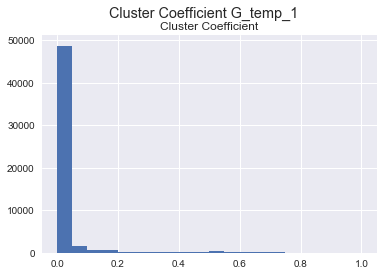

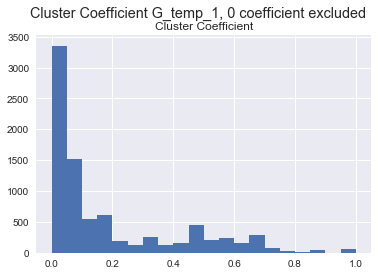

In [32]:
df_cluster_score_temp_1.hist(column='Cluster Coefficient', bins = 20);
plt.suptitle("Cluster Coefficient G_temp_1")
plt.show()

df_cluster_score_temp_1_excl = df_cluster_score_temp_1.loc[df_cluster_score_temp_1['Cluster Coefficient'] != 0.0]
df_cluster_score_temp_1_excl.hist(column='Cluster Coefficient', bins = 20);
plt.suptitle("Cluster Coefficient G_temp_1, 0 coefficient excluded")
plt.show()

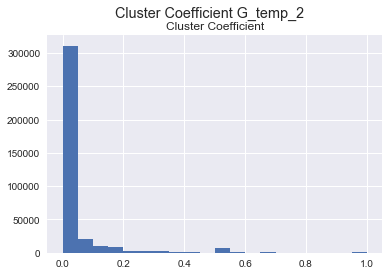

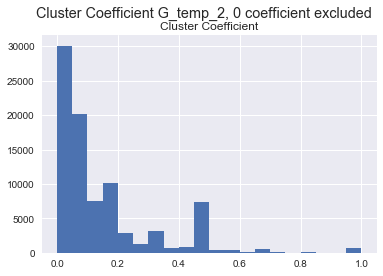

In [33]:
df_cluster_score_temp_2.hist(column='Cluster Coefficient', bins = 20);
plt.suptitle("Cluster Coefficient G_temp_2")
plt.show()

df_cluster_score_temp_2_excl = df_cluster_score_temp_2.loc[df_cluster_score_temp_2['Cluster Coefficient'] != 0.0]
df_cluster_score_temp_2_excl.hist(column='Cluster Coefficient', bins = 20);
plt.suptitle("Cluster Coefficient G_temp_2, 0 coefficient excluded")
plt.show()

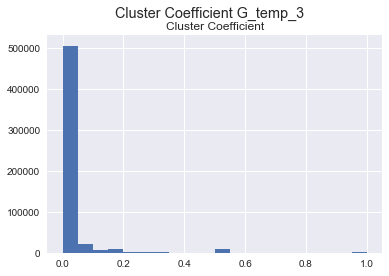

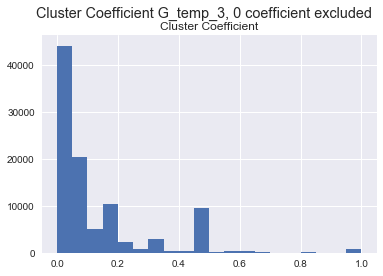

In [34]:
df_cluster_score_temp_3.hist(column='Cluster Coefficient', bins = 20);
plt.suptitle("Cluster Coefficient G_temp_3")
plt.show()

df_cluster_score_temp_3_excl = df_cluster_score_temp_3.loc[df_cluster_score_temp_3['Cluster Coefficient'] != 0.0]
df_cluster_score_temp_3_excl.hist(column='Cluster Coefficient', bins = 20);
plt.suptitle("Cluster Coefficient G_temp_3, 0 coefficient excluded")
plt.show()

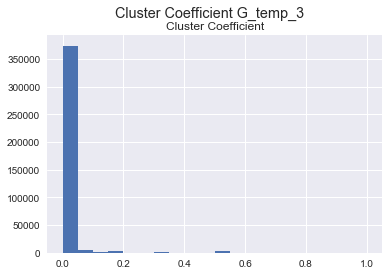

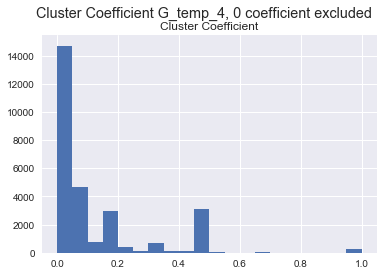

In [35]:
df_cluster_score_temp_4.hist(column='Cluster Coefficient', bins = 20);
plt.suptitle("Cluster Coefficient G_temp_3")
plt.show()

df_cluster_score_temp_4_excl = df_cluster_score_temp_4.loc[df_cluster_score_temp_4['Cluster Coefficient'] != 0.0]
df_cluster_score_temp_4_excl.hist(column='Cluster Coefficient', bins = 20);
plt.suptitle("Cluster Coefficient G_temp_4, 0 coefficient excluded")
plt.show()

As explained in task 1, an ECDF function gives us more insight into the cluster coefficient distribution throughout the network. A network could have for instance some very clustered parts and some less clustered parts, while another network could have many nodes with a similar, average clustering coefficient. So, we want to consider the distribution of clustering coefficient. Below, this distribution is plotted as a cumulated plot, again for each of the four graphs. Note that we plot the graphs, excluding the nodes with a cluster coefficient of 0 because otherwise the graphs would not give very much information.

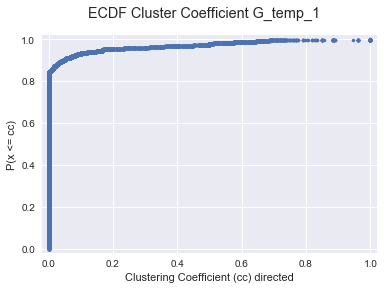

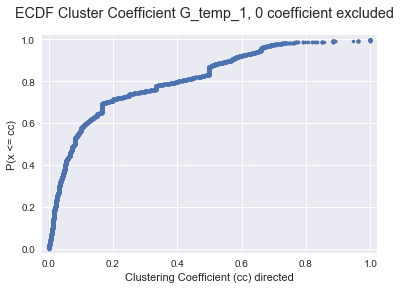

In [36]:
x = np.sort(df_cluster_score_temp_1['Cluster Coefficient'])
y = np.arange(1, len(x) + 1 )/ len(x)
_ = plt.plot(x,y, marker=".", linestyle = 'none')
_ = plt.xlabel('Clustering Coefficient (cc) directed')
_ = plt.ylabel('P(x <= cc)')
_ = plt.suptitle("ECDF Cluster Coefficient G_temp_1")
plt.margins(0.02) #keeps data off plot edges (i.e. 2% buffer all around the plot)
plt.show()

x = np.sort(df_cluster_score_temp_1_excl['Cluster Coefficient'])
y = np.arange(1, len(x) + 1 )/ len(x)
_ = plt.plot(x,y, marker=".", linestyle = 'none')
_ = plt.xlabel('Clustering Coefficient (cc) directed')
_ = plt.ylabel('P(x <= cc)')
_ = plt.suptitle("ECDF Cluster Coefficient G_temp_1, 0 coefficient excluded")
plt.margins(0.02) #keeps data off plot edges (i.e. 2% buffer all around the plot)
plt.show()

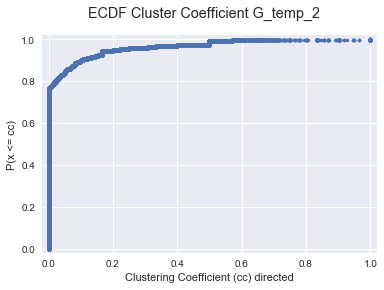

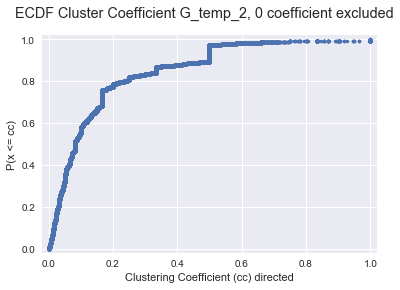

In [37]:
x = np.sort(df_cluster_score_temp_2['Cluster Coefficient'])
y = np.arange(1, len(x) + 1 )/ len(x)
_ = plt.plot(x,y, marker=".", linestyle = 'none')
_ = plt.xlabel('Clustering Coefficient (cc) directed')
_ = plt.ylabel('P(x <= cc)')
_ = plt.suptitle("ECDF Cluster Coefficient G_temp_2")
plt.margins(0.02) #keeps data off plot edges (i.e. 2% buffer all around the plot)
plt.show()

x = np.sort(df_cluster_score_temp_2_excl['Cluster Coefficient'])
y = np.arange(1, len(x) + 1 )/ len(x)
_ = plt.plot(x,y, marker=".", linestyle = 'none')
_ = plt.xlabel('Clustering Coefficient (cc) directed')
_ = plt.ylabel('P(x <= cc)')
_ = plt.suptitle("ECDF Cluster Coefficient G_temp_2, 0 coefficient excluded")
plt.margins(0.02) #keeps data off plot edges (i.e. 2% buffer all around the plot)
plt.show()

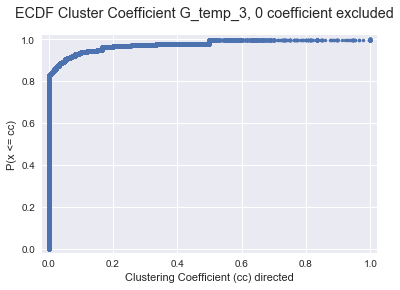

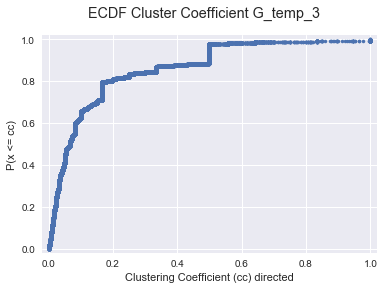

In [38]:
x = np.sort(df_cluster_score_temp_3['Cluster Coefficient'])
y = np.arange(1, len(x) + 1 )/ len(x)
_ = plt.plot(x,y, marker=".", linestyle = 'none')
_ = plt.xlabel('Clustering Coefficient (cc) directed')
_ = plt.ylabel('P(x <= cc)')
_ = plt.suptitle("ECDF Cluster Coefficient G_temp_3, 0 coefficient excluded")
plt.margins(0.02) #keeps data off plot edges (i.e. 2% buffer all around the plot)
plt.show()

x = np.sort(df_cluster_score_temp_3_excl['Cluster Coefficient'])
y = np.arange(1, len(x) + 1 )/ len(x)
_ = plt.plot(x,y, marker=".", linestyle = 'none')
_ = plt.xlabel('Clustering Coefficient (cc) directed')
_ = plt.ylabel('P(x <= cc)')
_ = plt.suptitle("ECDF Cluster Coefficient G_temp_3")
plt.margins(0.02) #keeps data off plot edges (i.e. 2% buffer all around the plot)
plt.show()

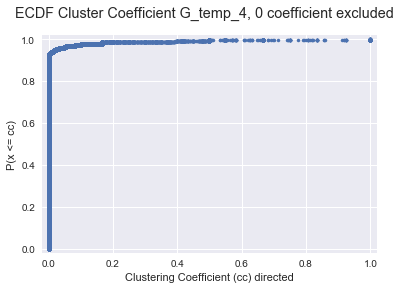

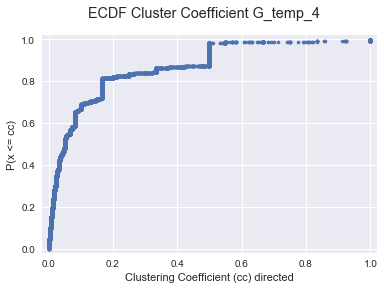

In [39]:
x = np.sort(df_cluster_score_temp_4['Cluster Coefficient'])
y = np.arange(1, len(x) + 1 )/ len(x)
_ = plt.plot(x,y, marker=".", linestyle = 'none')
_ = plt.xlabel('Clustering Coefficient (cc) directed')
_ = plt.ylabel('P(x <= cc)')
_ = plt.suptitle("ECDF Cluster Coefficient G_temp_4, 0 coefficient excluded")
plt.margins(0.02) #keeps data off plot edges (i.e. 2% buffer all around the plot)
plt.show()

x = np.sort(df_cluster_score_temp_4_excl['Cluster Coefficient'])
y = np.arange(1, len(x) + 1 )/ len(x)
_ = plt.plot(x,y, marker=".", linestyle = 'none')
_ = plt.xlabel('Clustering Coefficient (cc) directed')
_ = plt.ylabel('P(x <= cc)')
_ = plt.suptitle("ECDF Cluster Coefficient G_temp_4")
plt.margins(0.02) #keeps data off plot edges (i.e. 2% buffer all around the plot)
plt.show()

The ECDF's and histograms where the zero cluster coefficients are excluded gives us more insight into the cluster coefficient of the remaining nodes in the network. So why do we exclude these zero cluster coefficient nodes. As seen in task 1, these are the nodes that are the centre of a star like network, where the centre node only has outgoing edges, and no incoming edges. This could be a image, which is used in many different (sub) topics of a wikipedia page. However, these type of nodes that are the with a cluster coefficient of 0 and only have outgoing edge(s) are not interesting for the network analysis. We see that in every graph there are a lot of nodes with a cluster coefficient of 0, and they will dominate the plots too much. 


In $G_{temp-1}$ we see that around 80% of the non-zero cluster coefficient nodes have a cluster coefficient of 0.4 (or less). In $G_{temp-2}$, 80% of the non-zero cluster coefficient nodes have a cluster coefficient of approximately 0.25 (or less). In $G_{temp-3}$, around 80% of the non-zero cluster coefficient nodes have a cluster coefficient of approximately 0.18 (or less) and finally in $G_{temp-4}$ 80% of the non-zero cluster coefficient nodes have a cluster coefficient of around 0.18 (or less). We see a big difference between the first graph $G_{temp-1}$ and the third and fourth graph $G_{temp-3}$ and $G_{temp-4}$. This means that $G_{temp-1}$ is has relatively high cluster coefficients among the nodes, so the connectivity in this graph between the nodes themselves are quite high. In constrast to $G_{temp-3}$ and $G_{temp-4}$, where 80% of the non-zero cluster coefficient nodes have less then half of the cluster coefficient compared to $G_{temp-1}$. So $G_{temp-3}$ and $G_{temp-4}$ are more clustered, i.e. the connectedness between the nodes is low. The average cluster coefficient of these two graphs is also lower compared to the first two, so indeed the ECDF are in line with the average cluster coefficients of these two graphs. The first graph is the one with the highest clustering coefficient, despite the fact that the average neighbor degree and average degree of a node is not the highest in $G_{temp-1}$, but in $G_{temp-2}$. $G_{temp-1}$ contains the first links that are added to wikipedia, because in the year 2000 wikipedia was not that large compared to its size nowadays. When a wikipedia page is started, the first subtopics are probably the topics that are obvious too mention, i.e. they have a high relevance to each other (all of them!). However, over time people will do more research about the specific topic, so more information is added to the page. We can immediately see from the results above that adding links to the wikipedia page does not increase the clustering, but decreases it. The new discovered topics can be related to the original topic, but we often see that these topics are much less related to the other sub-topics. So, the wikipedia page grows because the topic can be become more popular, but the subtopics become less related to each other because the topic can have multiple definitions and or interpretations. Also, a wikipedia page can be changed by everyone. When a lot of people add information to the wikipedia page, it doesn't mean that this is good information. The hyperlinks they add to a subtopic of the main topic can be good, however it can be something completely different than the sub topic that someone else is adding. 

Throughout the years we see that there are more edges removed, however the clustering coefficient decreases tremendously when we look at the last graph. The wikipedia database has so many hyperlinks on it, that the network can be seen as a "spaghetti"-network: many clusters in the network with a very low connectivity between them selves. Over time, much more wikipedia pages are added, translated from other languages and so on. Therefore the connectedness between the hyperlinks themselves will obviously decrease. The network is fractioned. 

### Largest Connected Component: Temporal Network analysis
Before analyzing the largest connected component, we have to choose propiate time intervals. The largest connected component is the component with the most links in it. In task 1 we learned that the largest connected component of the static network was much larger than the second largest component. Recall that the theory of the largest connected component only counts for undirected graphs. Therefore, if we talk about graphs in this paragraph, we speak about undirected graphs. We choose the same time-stamps as we did in the cluster coefficient temporal analysis, for the same reasons. 

In [40]:
und_G_temp_1 = nx.to_undirected(G_temp_1)
num_connected_components_temp_1 = nx.number_connected_components(und_G_temp_1)
num_connected_components_temp_1

261

In [41]:
und_G_temp_2 = nx.to_undirected(G_temp_2)
num_connected_components_temp_2 = nx.number_connected_components(und_G_temp_2)
num_connected_components_temp_2

2299

In [42]:
und_G_temp_3 = nx.to_undirected(G_temp_3)
num_connected_components_temp_3 = nx.number_connected_components(und_G_temp_3)
num_connected_components_temp_3

5652

In [43]:
und_G_temp_4 = nx.to_undirected(G_temp_4)
num_connected_components_temp_4 = nx.number_connected_components(und_G_temp_4)
num_connected_components_temp_4

8715

We see that the number of connected components becomes giganticly larger from the first graph $G_{temp-1}$ to the second graph $G_{temp-2}$. This could have different reasons: 1) the number of links in $G_{temp-2}$ is much larger compared to the number of links in $G_{temp-2}$ and 2) the average (neighbor) degree of the nodes in $G_{temp-2}$ is also much larger compared to $G_{temp-1}$. One could state a hypotheses that the number of connected components is in relation to the number of links in the graph and/or to the average (neighbor) degree of the nodes in the graph. For each graph we will look at how large the largest connected component is, i.e. how many nodes ther are included in it. 

In [44]:
len(max(nx.connected_components(und_G_temp_1), key=len))

53334

In [45]:
len(max(nx.connected_components(und_G_temp_2), key=len))

364599

In [46]:
len(max(nx.connected_components(und_G_temp_3), key=len))

551204

In [47]:
len(max(nx.connected_components(und_G_temp_4), key=len))

369413

The four print results above are the size of the LCC in each graph, i.e. how many nodes the LCC contains. We see that for the chosen time intervals, the difference between each graph is significant. Therefore we will not change the time-intervals for the next analysis. In the following cells we write the connected componentes to <i>.edgelist</i> for each graph, so that we can use these files later one without calculating them again. After that is done, we check for each graph how many components are of size larger than $i$, for $0 \leq i \leq 18$, to see how the components are distributed among the network. 

In [48]:
#list_connected_components_temp_1 = list(nx.connected_component_subgraphs(und_G_temp_1))
#list_connected_components_temp_2 = list(nx.connected_component_subgraphs(und_G_temp_2))
#list_connected_components_temp_3 = list(nx.connected_component_subgraphs(und_G_temp_3))
#list_connected_components_temp_4 = list(nx.connected_component_subgraphs(und_G_temp_4))

In [49]:
def write_edgelist(list_connected_components, temp_number):
    for i in range(0, len(list_connected_components)):
        list_component = list_connected_components[i]
        nx.write_edgelist(list_component, "cc_temp_"+str(temp_number)+"/list_connected_components"+str(i)+".edgelist", data=False)

In [50]:
#write_edgelist(list_connected_components_temp_1, 1)

In [51]:
#write_edgelist(list_connected_components_temp_2, 2)

In [52]:
#write_edgelist(list_connected_components_temp_3, 3)

In [53]:
#write_edgelist(list_connected_components_temp_4, 4)

In [54]:
def check_size_components(length, number_of_connected_components, temp_number):
    count = 0
    for i in range(0, number_of_connected_components):
        fh = open("cc_temp_"+str(temp_number)+"/list_connected_components"+str(i)+".edgelist", 'rb')
        G_component = nx.read_edgelist(fh,create_using=nx.Graph())
        fh.close()
        if len(G_component) > length:
            count +=1
            #print("cc_temp_"+str(temp_number)+"/list_connected_components"+str(i)+".edgelist")
    return count

In [55]:
#cc_temp_1 = { 'Number of components': [check_size_components(i, num_connected_components_temp_1, 1) for i in range(0,19)], 'Connected component size, strictly larger than': [i for i in range(0,19)]}
#df_cc_temp_1 = pd.DataFrame(data=cc_temp_1)

In [56]:
#cc_temp_2 = { 'Number of components': [check_size_components(i, num_connected_components_temp_2, 2) for i in range(0,19)], 'Connected component size, strictly larger than': [i for i in range(0,19)]}
#df_cc_temp_2 = pd.DataFrame(data=cc_temp_2)

In [57]:
#cc_temp_3 = { 'Number of components': [check_size_components(i, num_connected_components_temp_3, 3) for i in range(0,19)], 'Connected component size, strictly larger than': [i for i in range(0,19)]}
#df_cc_temp_3 = pd.DataFrame(data=cc_temp_3)

In [58]:
#cc_temp_4 = { 'Number of components': [check_size_components(i, num_connected_components_temp_4, 4) for i in range(0,19)], 'Connected component size, strictly larger than': [i for i in range(0,19)]}
#df_cc_temp_4 = pd.DataFrame(data=cc_temp_4)

In [59]:
#df_cc_temp_1.to_csv('data/df_cc_temp_1.csv')
#df_cc_temp_2.to_csv('data/df_cc_temp_2.csv')
#df_cc_temp_3.to_csv('data/df_cc_temp_3.csv')
#df_cc_temp_4.to_csv('data/df_cc_temp_4.csv')

In [60]:
df_cc_temp_1 = pd.read_csv('data/df_cc_temp_1.csv')
df_cc_temp_2 = pd.read_csv('data/df_cc_temp_2.csv')
df_cc_temp_3 = pd.read_csv('data/df_cc_temp_3.csv')
df_cc_temp_4 = pd.read_csv('data/df_cc_temp_4.csv')

df_cc_temp_1.drop(['Unnamed: 0'], axis = 1, inplace = True)
df_cc_temp_2.drop(['Unnamed: 0'], axis = 1, inplace = True)
df_cc_temp_3.drop(['Unnamed: 0'], axis = 1, inplace = True)
df_cc_temp_4.drop(['Unnamed: 0'], axis = 1, inplace = True)

The results of the scores are written to a csv file. For each graph, we create a histogram to check the distribution of the component size larger than $i$ (for $0 \leq i \leq 18$) and we create a scatter plot of each graph

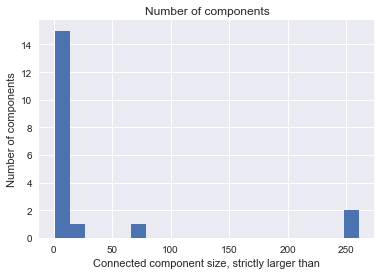

In [127]:
df_cc_temp_1.hist(column='Number of components', bins = 20);
_ = plt.xlabel('Connected component size, strictly larger than')
_ = plt.ylabel('Number of components')
plt.show()

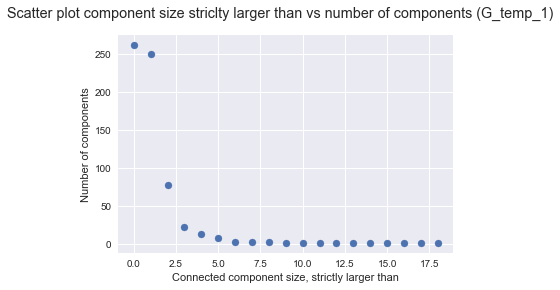

In [63]:
plt.scatter(df_cc_temp_1['Connected component size, strictly larger than'], df_cc_temp_1['Number of components'])
_ = plt.xlabel('Connected component size, strictly larger than')
_ = plt.ylabel('Number of components')
_ = plt.suptitle("Scatter plot component size striclty larger than vs number of components (G_temp_1)")
plt.show()

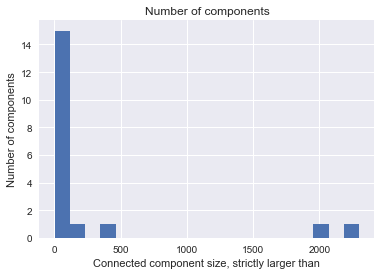

In [126]:
df_cc_temp_2.hist(column='Number of components', bins = 20);
_ = plt.xlabel('Connected component size, strictly larger than')
_ = plt.ylabel('Number of components')
plt.show()

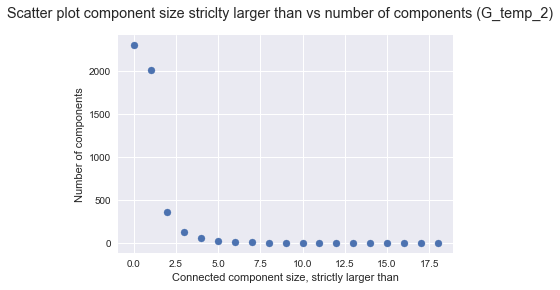

In [65]:
plt.scatter(df_cc_temp_2['Connected component size, strictly larger than'], df_cc_temp_2['Number of components'])
_ = plt.xlabel('Connected component size, strictly larger than')
_ = plt.ylabel('Number of components')
_ = plt.suptitle("Scatter plot component size striclty larger than vs number of components (G_temp_2)")
plt.show()

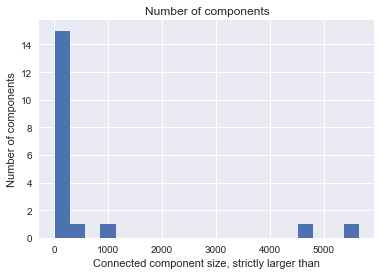

In [125]:
df_cc_temp_3.hist(column='Number of components', bins = 20);
_ = plt.xlabel('Connected component size, strictly larger than')
_ = plt.ylabel('Number of components')
plt.show()

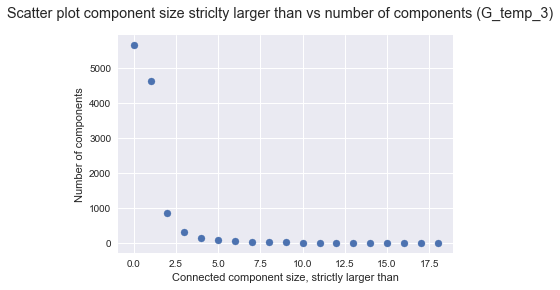

In [67]:
plt.scatter(df_cc_temp_3['Connected component size, strictly larger than'], df_cc_temp_3['Number of components'])
_ = plt.xlabel('Connected component size, strictly larger than')
_ = plt.ylabel('Number of components')
_ = plt.suptitle("Scatter plot component size striclty larger than vs number of components (G_temp_3)")
plt.show()

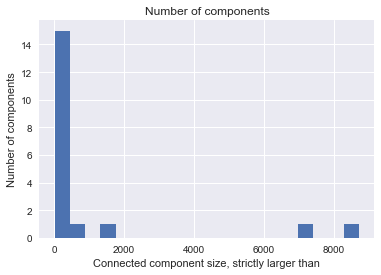

In [124]:
df_cc_temp_4.hist(column='Number of components', bins = 20);
_ = plt.xlabel('Connected component size, strictly larger than')
_ = plt.ylabel('Number of components')
plt.show()

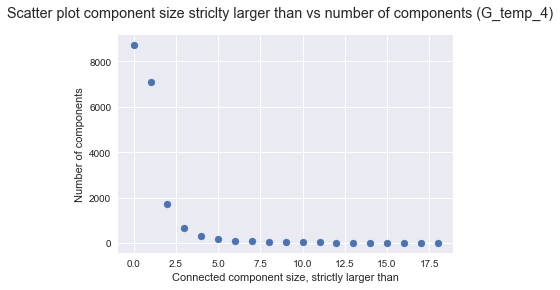

In [69]:
plt.scatter(df_cc_temp_4['Connected component size, strictly larger than'], df_cc_temp_4['Number of components'])
_ = plt.xlabel('Connected component size, strictly larger than')
_ = plt.ylabel('Number of components')
_ = plt.suptitle("Scatter plot component size striclty larger than vs number of components (G_temp_4)")
plt.show()

One can see that the <u>distribution</u> of the components size is very similar in each graph. The first bar of the histograms contains all the connected components, because every connected component has a size larger than zero. Then this size is increased and then we can see how many components there are of a size larger than a variable length $i$. Each graph has a very large number of small connected components, i.e. connected components of size 0 or 1. The histogram also shows us that every graph has 2 very large connected components. In the next analysis we will check if the largest connected components of each graph also have the same size, or that they have a difference between themselves. 

We see that in each scatter plot, the two-left most points are always the two outliers. Then there are a few connected components with a size larger than 2. However, in all the cases we see that the LCC is almost the entire network. From the cluster coefficient analysis we already saw that the cluster coefficient for each graph in these time intervals are very low. The histograms and scatterplots shows that the LCC contains almost the entire graph, and that there are also many other small components. This means that the network is very clustered/ fractioned. 

Above we plotted the how many components of a size striclty larger than $i$, for $0 \leq i \leq 18$, there are in each graph. However, since this measure is about the largest connected component, it can also be interesting how the LCC changes each year. Therefore, we define new time stamps for each year, i.e. $T_i = 2001 + i - 01 - 01 $ for $0 \leq i \leq 10$. 

In the next step we create for each time stamp a dataframe, so that we can create a directed graph of this dataframe later on. 

In [91]:
# Create timestamps
dTime={}
for x in range(0,11):
    year = 2002 + x
    T = datetime.datetime(year, 1, 1, 0, 0, 0)
    dTime["T{0}".format(x)]=T
dTime

{'T0': datetime.datetime(2002, 1, 1, 0, 0),
 'T1': datetime.datetime(2003, 1, 1, 0, 0),
 'T10': datetime.datetime(2012, 1, 1, 0, 0),
 'T2': datetime.datetime(2004, 1, 1, 0, 0),
 'T3': datetime.datetime(2005, 1, 1, 0, 0),
 'T4': datetime.datetime(2006, 1, 1, 0, 0),
 'T5': datetime.datetime(2007, 1, 1, 0, 0),
 'T6': datetime.datetime(2008, 1, 1, 0, 0),
 'T7': datetime.datetime(2009, 1, 1, 0, 0),
 'T8': datetime.datetime(2010, 1, 1, 0, 0),
 'T9': datetime.datetime(2011, 1, 1, 0, 0)}

In [94]:
# Create DataFrames for every timestamp
dfG={}
for x in range(0,10):
    T0 = "T{0}".format(x)
    T1 = "T{0}".format(x+1)
    T0 = dTime.get(T0)
    T1 = dTime.get(T1)
    df_G = temp_nw.copy()
    df_G = df_G[((df_G['start'] >= T0) & (df_G['start'] < T1)) | ((df_G['end'] > T0) & (df_G['end'] <= T1)) | 
                ((df_G['start'] < T0) & (df_G['end'] > T1))]
    dfG["df_G{0}".format(x)]=df_G
    print("df_G{0}".format(x) + ": " + str(df_G.shape))

df_G0: (56459, 4)
df_G1: (210603, 4)
df_G2: (502719, 4)
df_G3: (1115759, 4)
df_G4: (1685662, 4)
df_G5: (1758664, 4)
df_G6: (1618639, 4)
df_G7: (1331689, 4)
df_G8: (960662, 4)
df_G9: (443777, 4)


In [95]:
# Initialize an undirected graph G from each of the given pandas dataframes.
dG={}
for x in range(0,10):
    G = "df_G{0}".format(x)
    G = dfG.get(G)
    G = nx.from_pandas_dataframe(G, 'src', 'trg', edge_attr=None, create_using=nx.Graph())
    dG["G{0}".format(x)]=G

In [106]:
lstLCC = list()
lstTime = list()
for x in range(0,10):
    T = "{0}".format(2002+x) + " - " + "{0}".format(2002+x+1) 
    lstTime.append(T)
    G = "G{0}".format(x); G = dG.get(G)
    lstLCC.append(len(max(nx.connected_components(G), key=len)))
lcc = pd.DataFrame({'Time': lstTime, 'size LCC': lstLCC})
cols = lcc.columns.tolist()
cols = cols[-1:] + cols[:-1]
lcc = lcc[cols]
lcc

,size LCC,Time
0,18414,2002 - 2003
1,52591,2003 - 2004
2,111452,2004 - 2005
3,223189,2005 - 2006
4,340783,2006 - 2007
5,405902,2007 - 2008
6,427844,2008 - 2009
7,401336,2009 - 2010
8,344197,2010 - 2011
9,199435,2011 - 2012


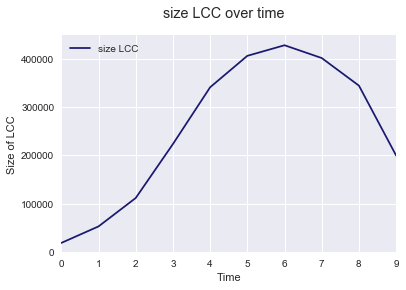

In [119]:
lcc.plot(color='midnightblue');
_ = plt.xlabel('Time')
_ = plt.ylabel('Size of LCC')
_ = plt.suptitle("size LCC over time")
plt.show()

We see that the LCC increases over time, until the year 2006. After 2006 the LCC decreases. We see that this plot is very similar compared to the number of links added/removed and average degree of the networks. This makes sense, since when a lot of links are removed, it's very likely that they are removed from the LCC. As we saw in the histograms and ECDFs of each graph, the LCC contains almost all the links in the entire graph. It is very interesting that from graph $G_{temp-3}$ (that has 5652 number of connected components) to graph $G_{temp-4}$ (that has 8715) the largest connected component decreases instead of increases. Intuitevely this seems not correct, but note that from the third to fourth graph there are more edges removed than added. Also, the way we create a graph is that only the nodes/edges are in the graph from the given timestamps. In $G_{temp-3}$ the graph has the largest LCC, as we can see form the plot above. When there are hyperlinks removed from the wikipedia page, it is very likely that these are the hyperlinks that are in the largest connected component of the graph. As we concluded in the cluster coefficient temporal analysis, the wikipedia data network becomes more fractioned after 2006. The LCC plot above confirms this conclusion. In task 1 it was hard to draw a conclusion about the LCC, because you don't see the changes of the size of the LCC over time. The only interestings found in task 1 were that the LCC contains almost all the articles in the wikipedia network, which is the same conclusion in task 2. As mentioned in task 1, it completely makes sense that there is one dominating connected component. This is because the graph is treated as an undirected graph. Therefore nodes with only outgoing or ingoing edges, immediately becomes more connected to other nodes, since the direction of the edges are not counted anymore. Over time, we see that the wikipedia domain becomes larger and larger, untill the year 2006. It could be that after 2006, the wikipedia comain is cleaned up, so that a lot of hyperlinks that don't have a additional value are removed from it. However, we cannot conclude this because we don't have enough information about the hyperlinks. 